In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import IPython
import IPython.display

In [2]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [3]:
buoy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51888 entries, 0 to 51887
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Spot Id                  51888 non-null  int64  
 1   Timestamp                51888 non-null  object 
 2   Significant Wave Height  51888 non-null  float64
 3   Peak Period              51888 non-null  float64
 4   Mean Period              51888 non-null  float64
 5   Peak Direction           51888 non-null  float64
 6   Peak Directional Spread  51888 non-null  float64
 7   Mean Direction           51888 non-null  float64
 8   Mean Directional Spread  51888 non-null  float64
 9   Latitude                 51888 non-null  float64
 10  Longitude                51888 non-null  float64
 11  Heading                  51888 non-null  float64
 12  Distance                 51794 non-null  float64
 13  Current Direction        51888 non-null  float64
dtypes: float64(12), int64(

In [4]:
date_time = pd.to_datetime(buoy_data.pop('Timestamp'), format='%Y-%m-%d %H:%M:%S')

In [5]:
buoy_data.head()

,Spot Id,Significant Wave Height,Peak Period,Mean Period,Peak Direction,Peak Directional Spread,Mean Direction,Mean Directional Spread,Latitude,Longitude,Heading,Distance,Current Direction
0,0,1.576,6.827,5.231,268.062,26.141,245.366,52.564,34.95782,290.06765,330.22,NaN,117.84
1,0,1.544,6.827,5.159,264.063,30.325,242.607,53.059,34.96202,290.06473,318.51,536.87,125.55
2,0,1.590,7.314,5.288,267.427,31.451,243.648,51.565,34.96605,290.06040,313.01,596.88,134.42
3,0,1.617,7.314,5.229,263.254,34.004,236.917,53.388,34.97025,290.05493,315.35,683.12,127.90
4,0,1.547,7.314,5.278,265.768,31.605,239.341,52.841,34.97540,290.04875,311.99,803.07,133.78


In [6]:
buoy_0_data = buoy_data[buoy_data['Spot Id'] == 0][1:-1].drop('Spot Id', axis=1)

In [7]:
buoy_0_data.head()

,Significant Wave Height,Peak Period,Mean Period,Peak Direction,Peak Directional Spread,Mean Direction,Mean Directional Spread,Latitude,Longitude,Heading,Distance,Current Direction
1,1.544,6.827,5.159,264.063,30.325,242.607,53.059,34.96202,290.06473,318.51,536.87,125.55
2,1.590,7.314,5.288,267.427,31.451,243.648,51.565,34.96605,290.06040,313.01,596.88,134.42
3,1.617,7.314,5.229,263.254,34.004,236.917,53.388,34.97025,290.05493,315.35,683.12,127.90
4,1.547,7.314,5.278,265.768,31.605,239.341,52.841,34.97540,290.04875,311.99,803.07,133.78
5,1.608,7.314,5.354,260.735,27.305,239.309,49.655,34.98177,290.04015,320.40,1056.45,120.34


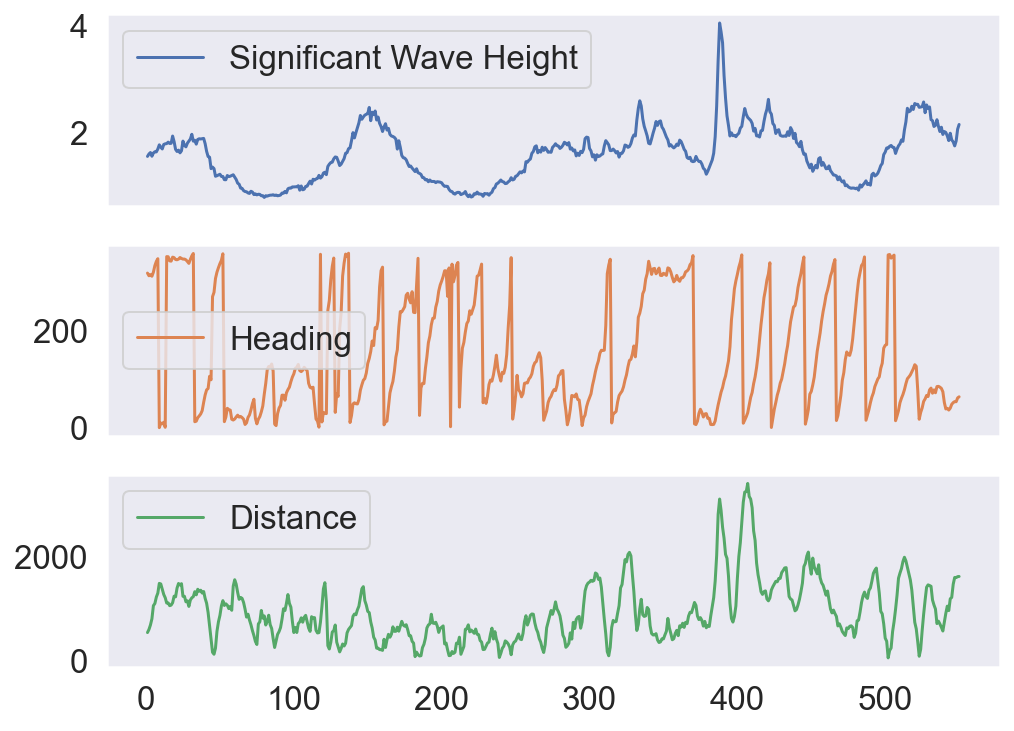

In [8]:
plot_cols = ['Significant Wave Height', 'Heading', 'Distance']
plot_features = buoy_0_data[plot_cols]
plot_features_index = date_time[:550]
_ = plot_features.plot(subplots=True)

In [9]:
buoy_0_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Significant Wave Height,550.0,1.567333,0.510648,0.77300,1.116250,1.606500,1.901250,4.05300
Peak Period,550.0,7.305735,0.953025,3.79300,6.827000,7.314000,7.877000,9.30900
Mean Period,550.0,5.469345,0.548142,4.11200,5.053000,5.464500,5.827500,7.17900
Peak Direction,550.0,212.660249,53.146588,15.25500,193.949000,223.890500,252.037750,356.34800
Peak Directional Spread,550.0,44.119873,11.978952,20.17400,35.973750,41.474000,49.968500,80.71900
Mean Direction,550.0,202.093335,52.943455,7.85700,185.189500,214.846500,231.081500,355.68700
Mean Directional Spread,550.0,53.437609,8.023944,30.70000,47.428250,52.330500,57.890750,80.12400
Latitude,550.0,35.806780,0.331458,34.96202,35.664070,35.710825,36.161698,36.48022
Longitude,550.0,290.733682,0.483313,289.97402,290.398733,290.600850,291.171490,291.83863
Heading,550.0,153.896327,117.212244,0.46000,53.822500,115.730000,275.255000,359.35000


Text(0, 0.5, 'Speed [m/s]')

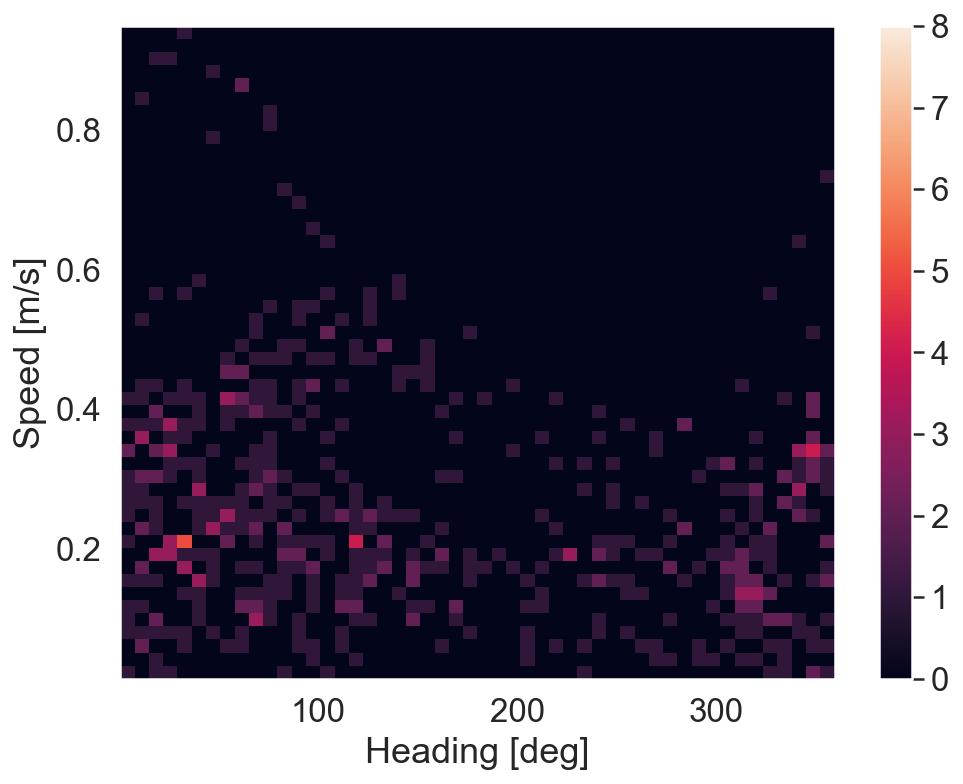

In [10]:
plt.hist2d(buoy_0_data['Heading'], buoy_0_data['Distance']/3600, bins=(50, 50), vmax=8)
plt.colorbar()
plt.xlabel('Heading [deg]')
plt.ylabel('Speed [m/s]')

In [11]:
speed = buoy_0_data.pop('Distance')/3600

heading_rad = buoy_0_data.pop('Heading')*np.pi / 180

buoy_0_data['Sx'] = speed*np.cos(heading_rad)
buoy_0_data['Sy'] = speed*np.sin(heading_rad)

(-0.5117170297135664,
 0.8680032451657879,
 -0.3685618402382551,
 0.781503539753023)

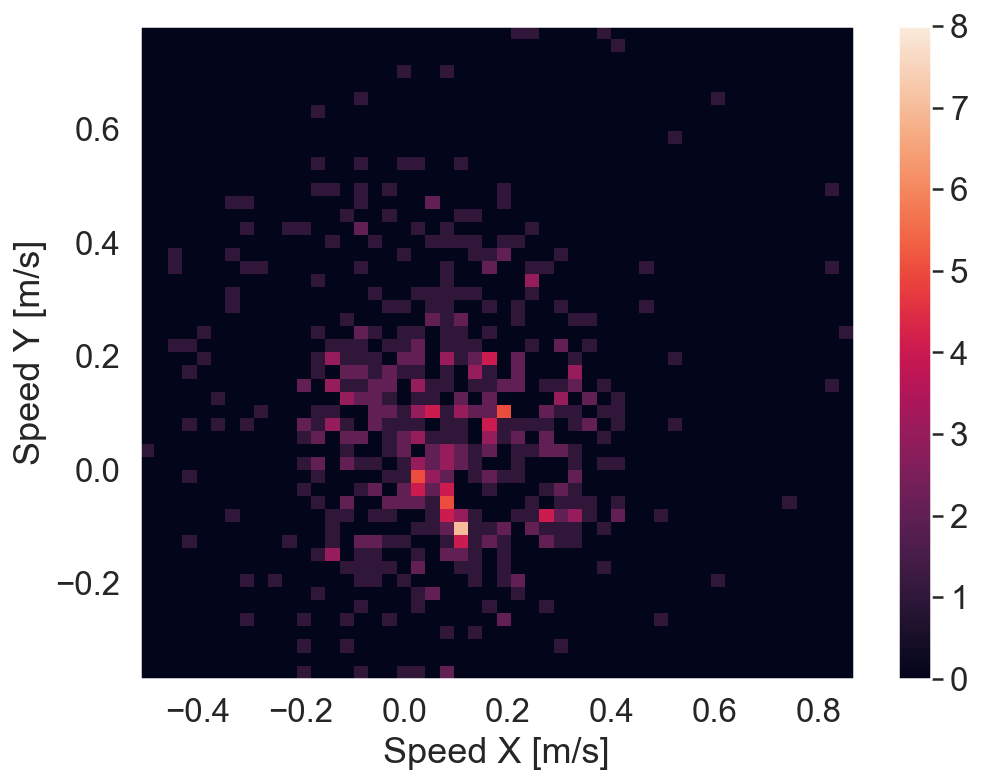

In [12]:
plt.hist2d(buoy_0_data['Sx'], buoy_0_data['Sy'], bins=(50, 50), vmax=8)
plt.colorbar()
plt.xlabel('Speed X [m/s]')
plt.ylabel('Speed Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [14]:
buoy_0_data.head()

,Significant Wave Height,Peak Period,Mean Period,Peak Direction,Peak Directional Spread,Mean Direction,Mean Directional Spread,Latitude,Longitude,Current Direction,Sx,Sy
1,1.544,6.827,5.159,264.063,30.325,242.607,53.059,34.96202,290.06473,125.55,0.111709,-0.098797
2,1.590,7.314,5.288,267.427,31.451,243.648,51.565,34.96605,290.06040,134.42,0.113096,-0.121239
3,1.617,7.314,5.229,263.254,34.004,236.917,53.388,34.97025,290.05493,127.90,0.134995,-0.133355
4,1.547,7.314,5.278,265.768,31.605,239.341,52.841,34.97540,290.04875,133.78,0.149237,-0.165803
5,1.608,7.314,5.354,260.735,27.305,239.309,49.655,34.98177,290.04015,120.34,0.226114,-0.187057


In [15]:
column_indices = {name: i for i, name in enumerate(buoy_0_data.columns)}

n = len(buoy_0_data)
train_df = buoy_0_data[0:int(n*0.7)]
val_df = buoy_0_data[int(n*0.7):int(n*0.9)]
test_df = buoy_0_data[int(n*0.9):]

num_features = buoy_0_data.shape[1]

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

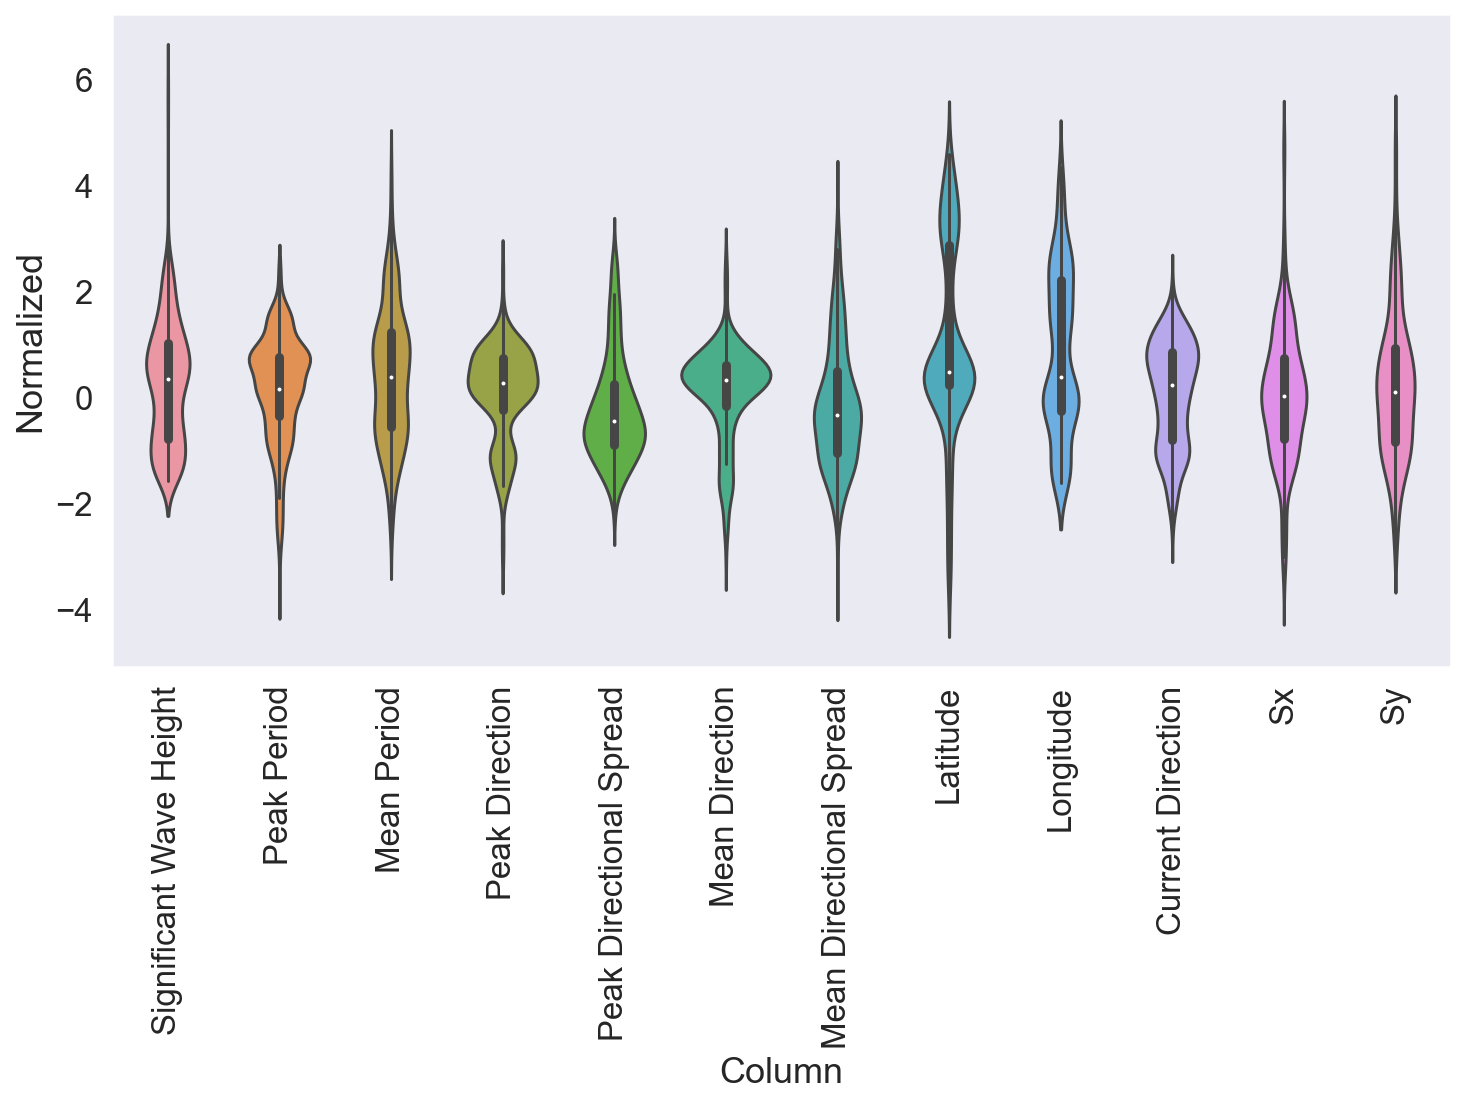

In [17]:
buoy_0_data_std = (buoy_0_data - train_mean) / train_std
buoy_0_data_std = buoy_0_data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=buoy_0_data_std)
_ = ax.set_xticklabels(buoy_0_data.keys(), rotation=90)

In [18]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([f'Total window size: {self.total_window_size}',
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Label column name(s): {self.label_columns}'])

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Latitude'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Latitude']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Latitude'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Latitude']

In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 12)
Inputs shape: (3, 6, 12)
Labels shape: (3, 1, 1)


In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='Latitude', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

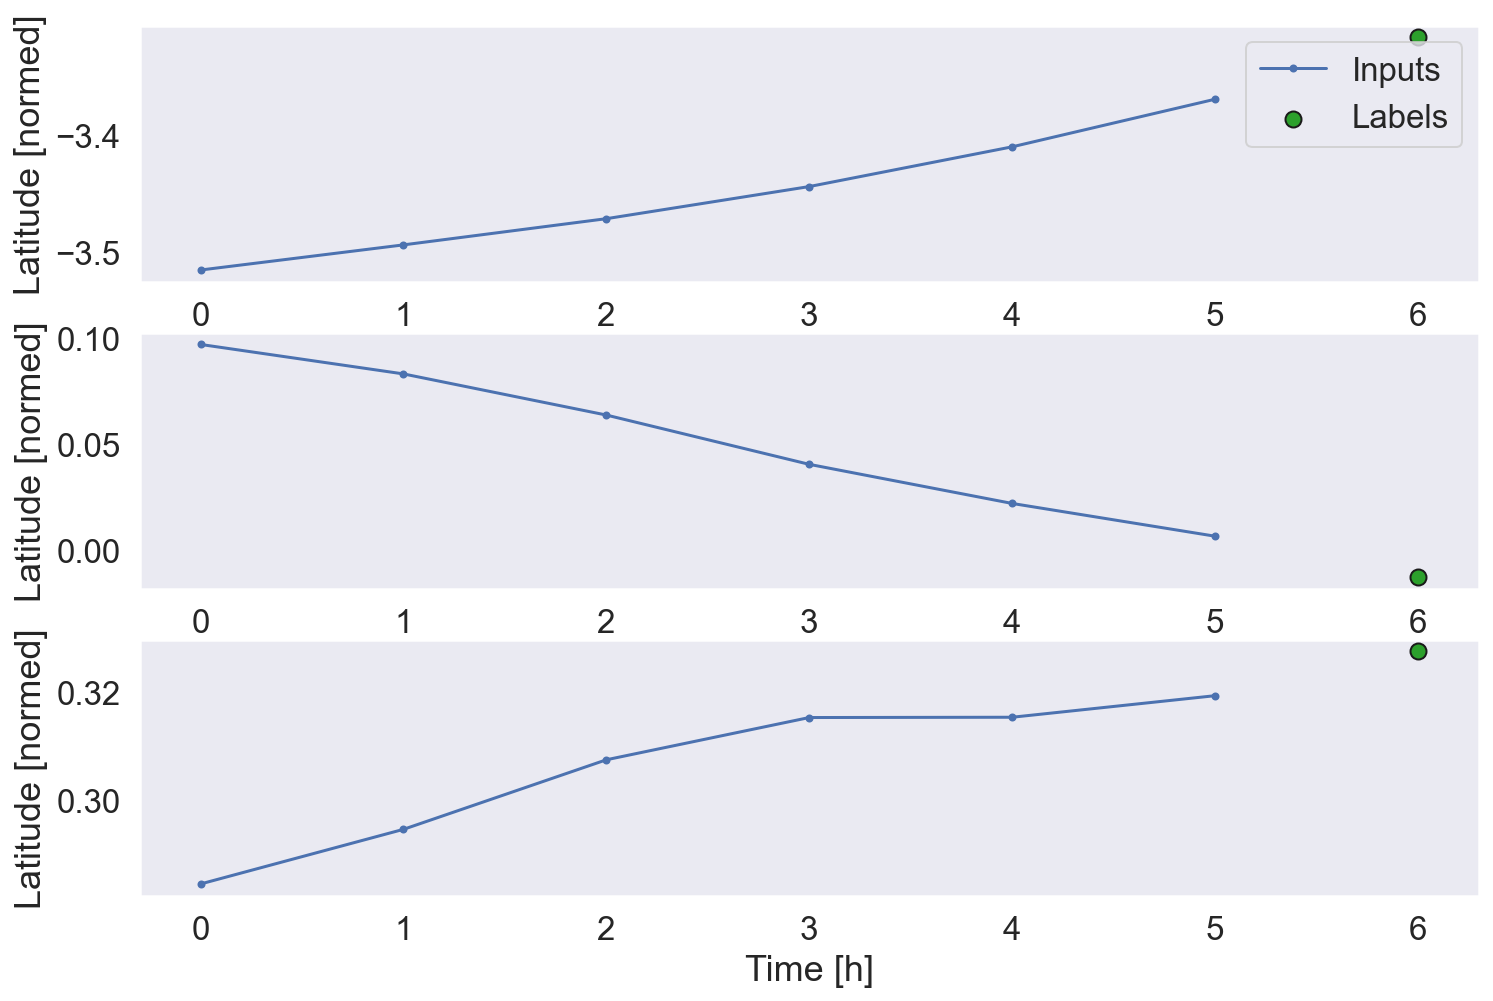

In [25]:
w2.plot()

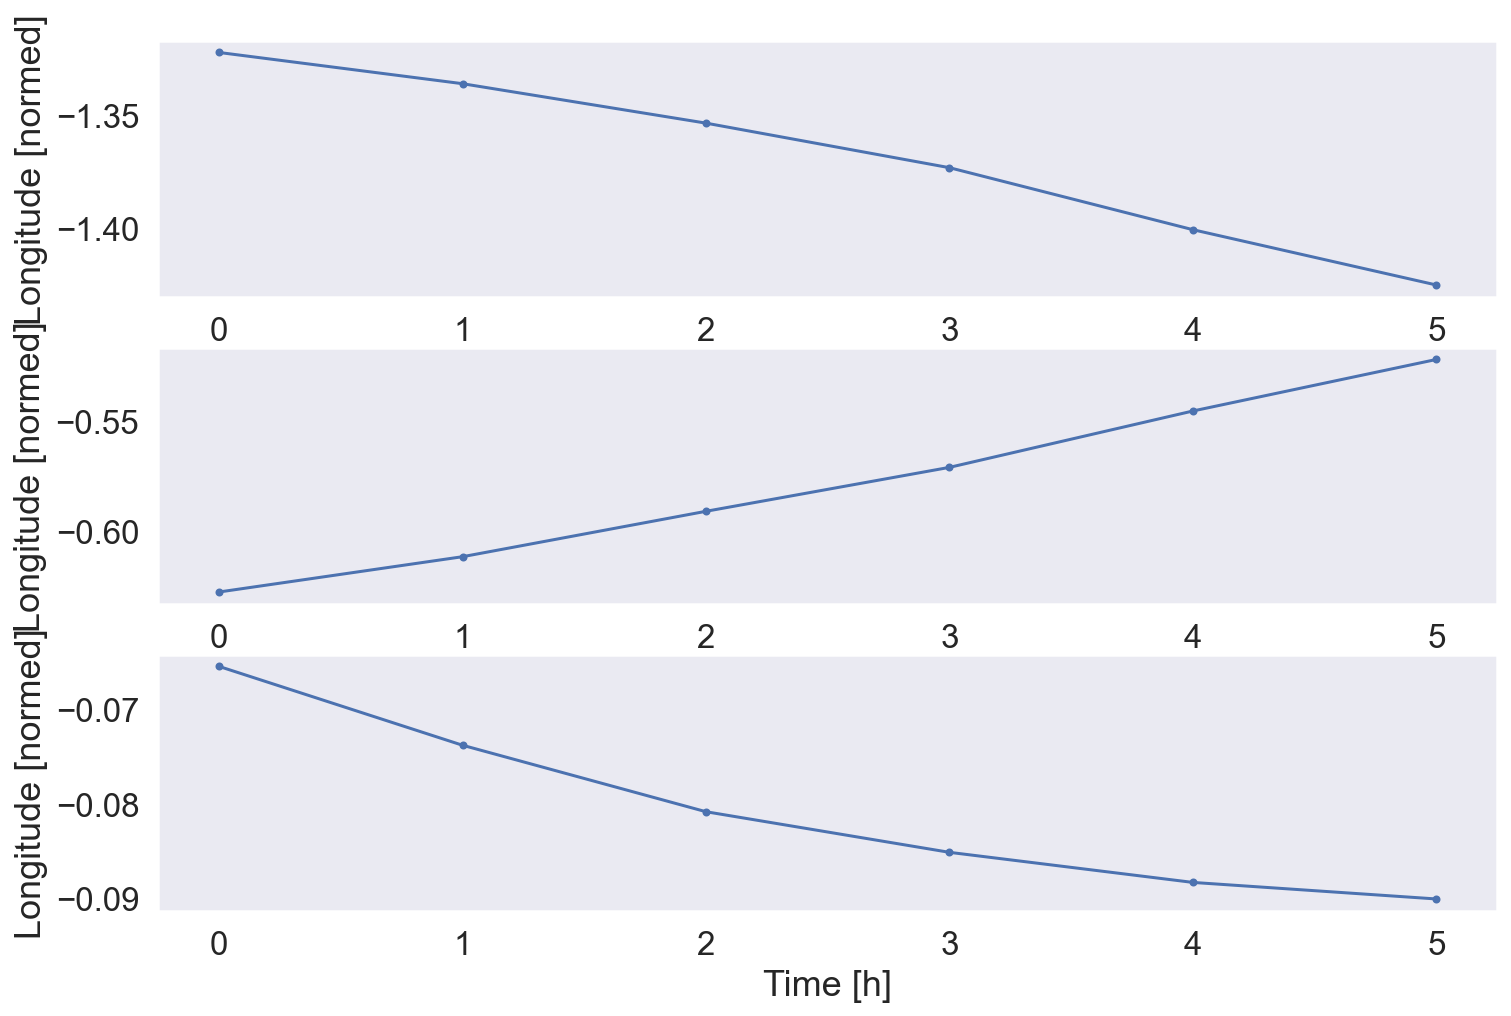

In [26]:
w2.plot(plot_col='Longitude')

In [27]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
              data=data,
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [28]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Latitude'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Latitude']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [33]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [34]:
baseline = Baseline(label_index=column_indices['Latitude'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_absolute_error: 0.0452


In [35]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['Latitude'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Latitude']

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


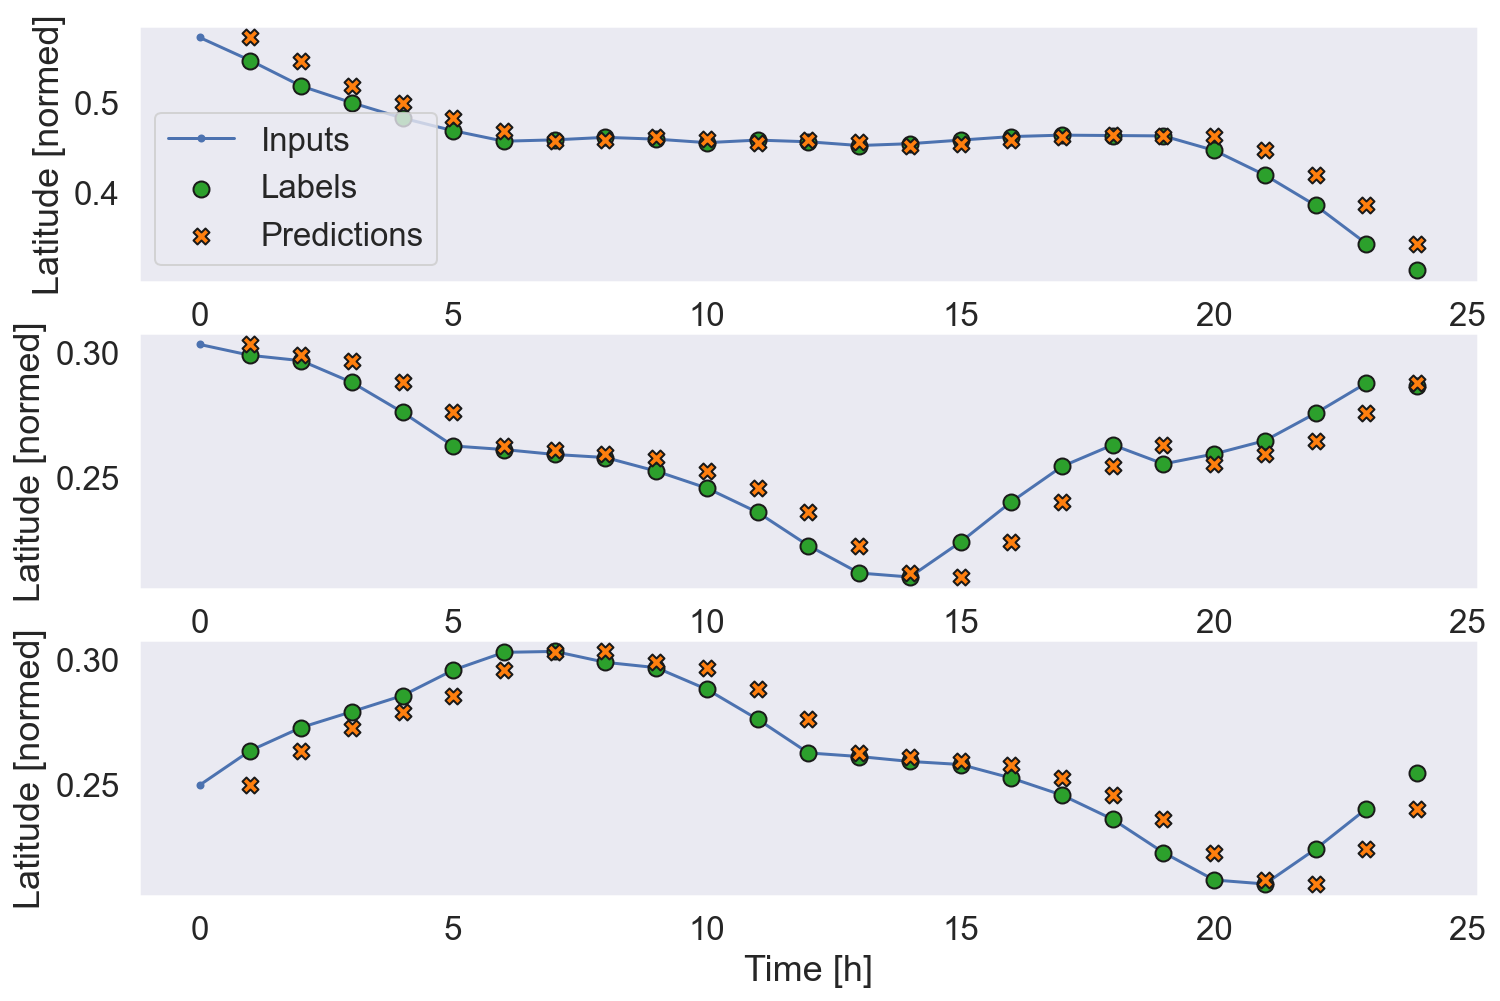

In [37]:
wide_window.plot(baseline)

In [38]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [39]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(),
                              metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
12/12 [==============================] - 0s 9ms/step - loss: 4.3603 - mean_absolute_error: 1.7110 - val_loss: 16.2503 - val_mean_absolute_error: 3.4250
Epoch 2/20
12/12 [==============================] - 0s 4ms/step - loss: 4.1879 - mean_absolute_error: 1.6765 - val_loss: 15.7978 - val_mean_absolute_error: 3.3802
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 4.0250 - mean_absolute_error: 1.6433 - val_loss: 15.3449 - val_mean_absolute_error: 3.3340
Epoch 4/20
12/12 [==============================] - 0s 5ms/step - loss: 3.8653 - mean_absolute_error: 1.6105 - val_loss: 14.8785 - val_mean_absolute_error: 3.2857
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 3.7108 - mean_absolute_error: 1.5775 - val_loss: 14.4698 - val_mean_absolute_error: 3.2429
Epoch 6/20
12/12 [==============================] - 0s 5ms/step - loss: 3.5620 - mean_absolute_error: 1.5457 - val_loss: 14.0618 - val_mean_absolute_error: 3.1996
Epoch 7/20
12/12 [====

In [42]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


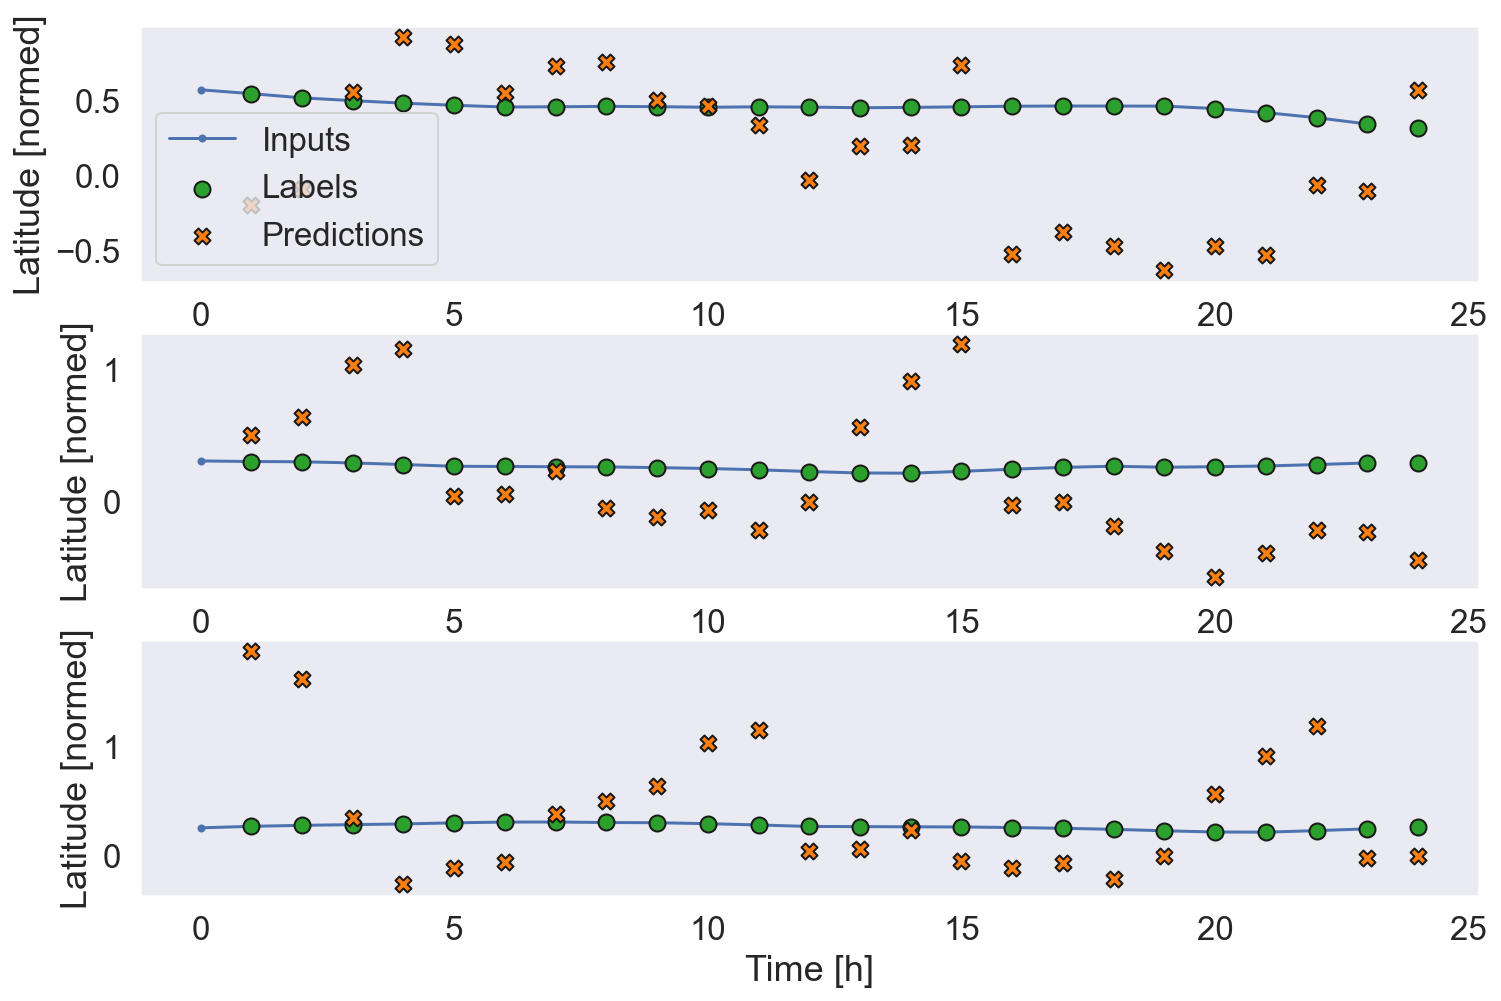

In [43]:
wide_window.plot(linear)

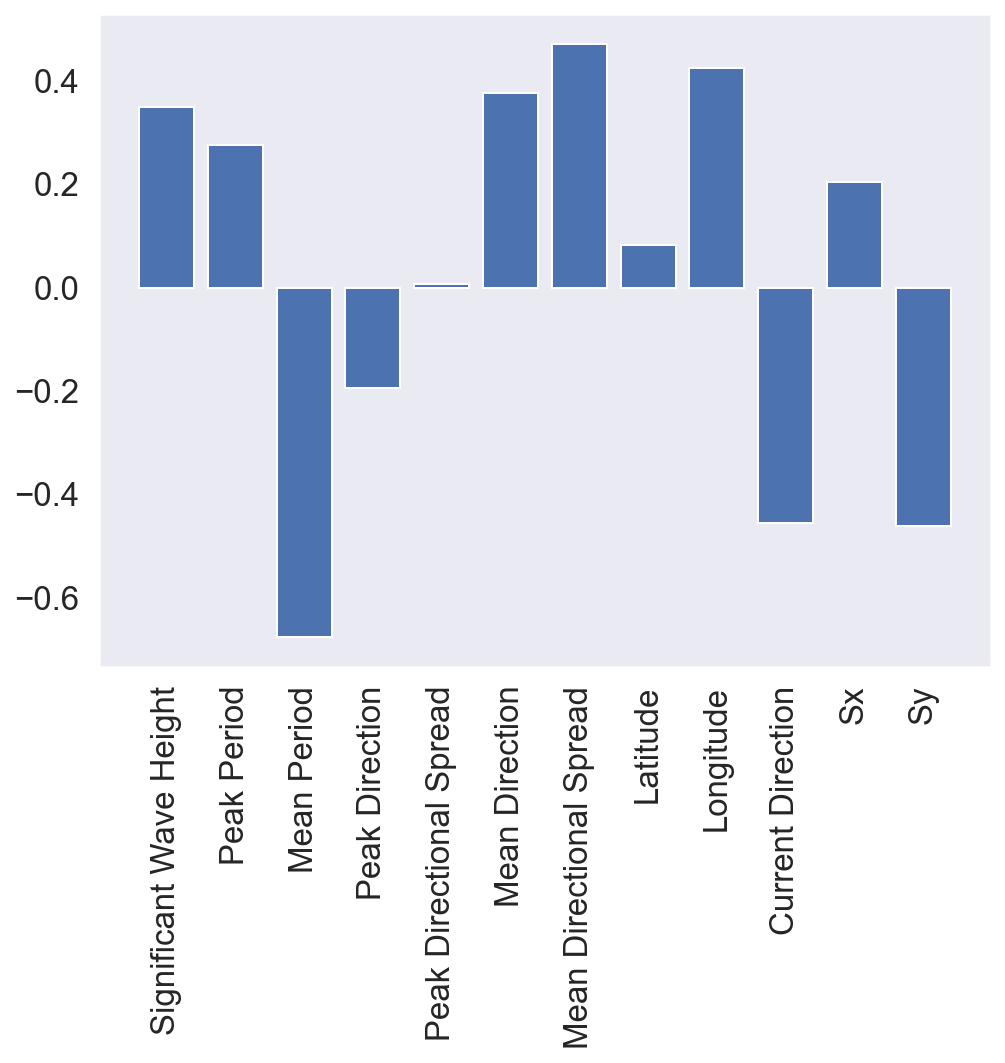

In [44]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [45]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
12/12 [==============================] - 1s 14ms/step - loss: 0.5908 - mean_absolute_error: 0.5001 - val_loss: 4.7208 - val_mean_absolute_error: 2.1305
Epoch 2/20
12/12 [==============================] - 0s 5ms/step - loss: 0.1806 - mean_absolute_error: 0.2696 - val_loss: 2.8686 - val_mean_absolute_error: 1.6336
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0575 - mean_absolute_error: 0.1778 - val_loss: 1.8310 - val_mean_absolute_error: 1.2636
Epoch 4/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0371 - mean_absolute_error: 0.1432 - val_loss: 1.5788 - val_mean_absolute_error: 1.1629
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0218 - mean_absolute_error: 0.1107 - val_loss: 1.4916 - val_mean_absolute_error: 1.1250
Epoch 6/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.0965 - val_loss: 1.2880 - val_mean_absolute_error: 1.0410
Epoch 7/20
12/12 [=========

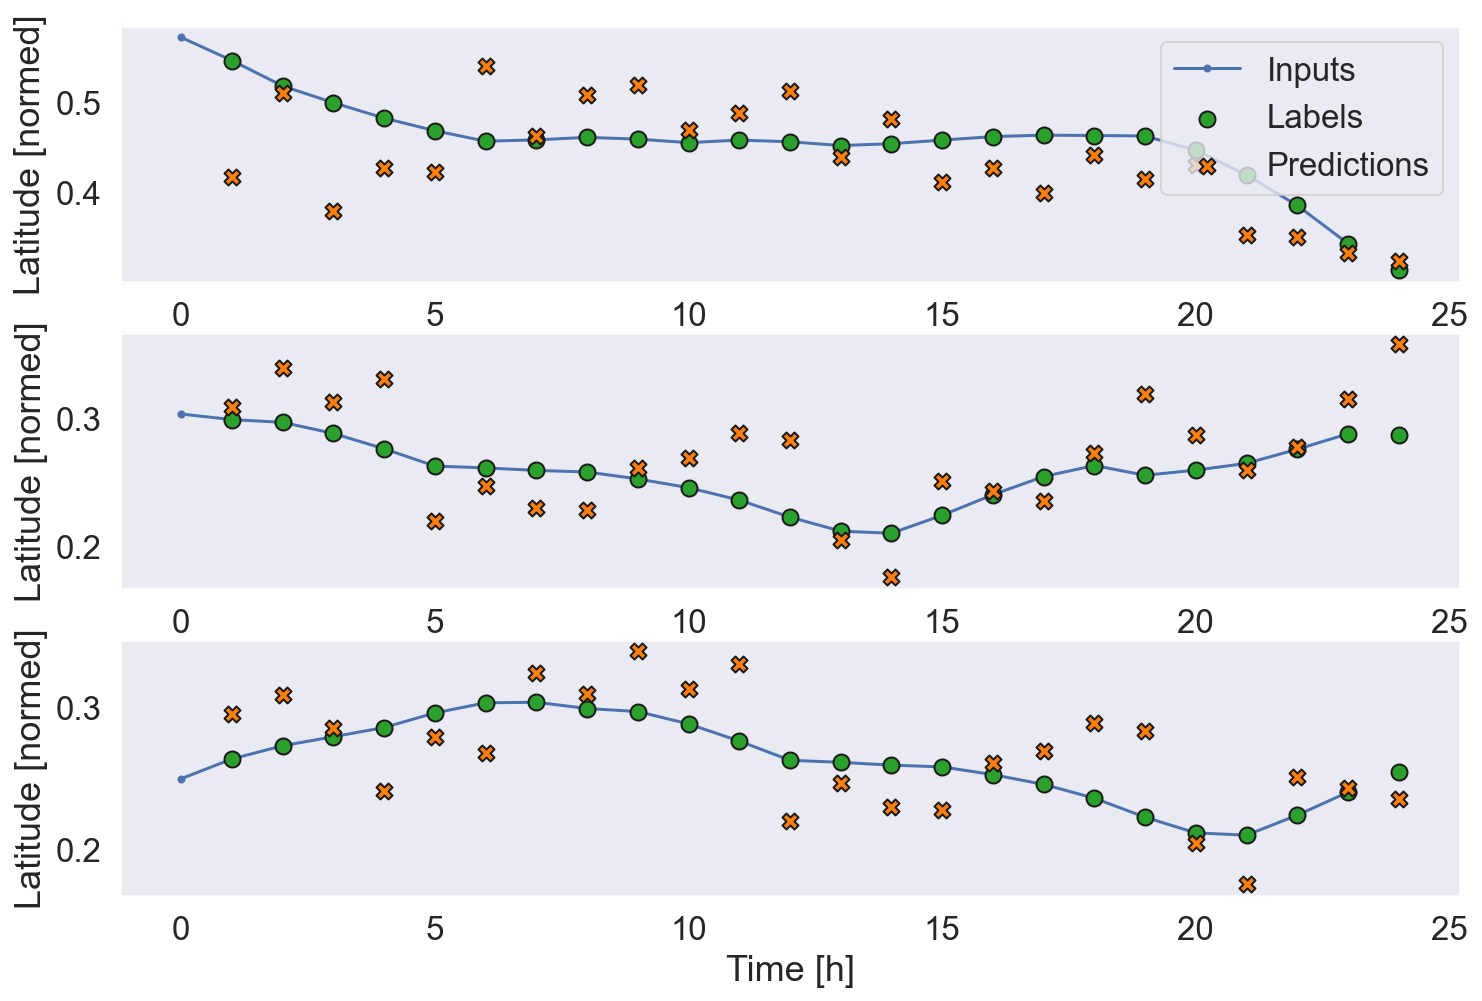

In [46]:
wide_window.plot(dense)